In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

### Get Block Group Geometries

In [ ]:
import os
os.getcwd()

In [ ]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/tl_2019_04_bg')

In [ ]:
az_bg = gpd.read_file('tl_2019_04_bg.shp')

In [ ]:
az_bg.plot()

In [ ]:
az_bg.head()

In [ ]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/')

pkl_in_temp = open('tempems_pkl_021120', 'rb')

df = pickle.load(pkl_in_temp)

key = df.filter(['tract'])
key.drop_duplicates(inplace=True)

In [ ]:
key.tract = key.tract *100

In [ ]:
key.tract.head()

In [ ]:
az_bg.TRACTCE = az_bg.TRACTCE.astype(float) 

In [ ]:
tempe_bg = az_bg.merge(key, left_on='TRACTCE', right_on='tract')

In [ ]:
tempe_bg.boundary.plot(figsize=(10,10))

In [ ]:
tempe_bg.GEOID.head()

### Query Block Group PDB Data From Census 

In [ ]:
year='2019'
dsource='pdb/blockgroup'
cols='State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17'
state='04'
county='013'
api_key='b76534619ffbdeef7355569c1b9cafd6a55fce2b'

In [ ]:
base_url = f'https://api.census.gov/data/{year}/{dsource}'

In [ ]:
data_url = f'{base_url}?get={cols}&for=block%20group:*&in=state:{state}&in=county:{county}&in=tract:*&key={api_key}'

In [ ]:
response=requests.get(data_url)

In [ ]:
data=response.json()
pdb_bg=pd.DataFrame(data[1:], columns=data[0])

In [ ]:
pdb_bg.head()

In [ ]:
tempe = pdb_bg.merge(tempe_bg, left_on='GIDBG', right_on='GEOID')

In [ ]:
tempe.head()

### Import and Merge with Tempe EMS calls

In [ ]:
#tempe ems 
eurl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Opioid_Calls/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
tempems = gpd.read_file(eurl)

In [ ]:
tempems = tempems[tempems['Opioid_Use'] == 'Yes']
tempems.shape

In [ ]:
tempems.head()

In [ ]:
tempe = gpd.GeoDataFrame(tempe, geometry=tempe.geometry)

In [ ]:
tempe.plot()

In [ ]:
tempe_tract = pd.DataFrame()
for i in range(len(tempe)):
    df = tempems[tempems.within(tempe.loc[i,'geometry'])]
    df['GIDBG'] = tempe.loc[i,'GIDBG']
    tempe_tract = pd.concat([tempe_tract, df], axis=0)

In [ ]:
tempe_tract.columns

In [ ]:
tempems.shape

In [ ]:
tempe_tract.shape

In [ ]:
tempe_tract = tempe_tract.merge(tempe, on='GIDBG')

In [ ]:
tempe_tract.shape

In [ ]:
tempe_tract.columns

In [ ]:
tempe_tract.drop('geometry_y', inplace=True, axis=1)

In [ ]:
tempe_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
tempe_tract = gpd.GeoDataFrame(tempe_tract, geometry=tempe_tract.geometry)

In [ ]:
tempe_tract.shape

In [ ]:
tempe_tract.head()

In [ ]:
tempe_tract.columns

In [ ]:
from time import strptime
for i in range(len(tempe_tract)):
    tempe_tract['Month'][i] = strptime(tempe_tract['Month'][i], '%B').tm_mon
    

In [ ]:
tempe_tract['year_month']= tempe_tract['Year'] + tempe_tract['Month']/100

In [ ]:
op = tempe_tract.filter(['GIDBG', 'year_month', 'Opioid_Use'])

In [ ]:
op.head()

In [ ]:
op = op.groupby(by=[op['GIDBG'], op['year_month']]).count()

In [ ]:
op.reset_index(inplace=True)

In [ ]:
var = ['geometry', 'GIDBG', 'Tot_Population_ACS_13_17','pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17','Med_HHD_Inc_BG_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','Med_House_Value_BG_ACS_13_17','pct_College_ACS_13_17',
       'year_month']

In [ ]:
tempe_tract = tempe_tract.filter(var)

In [ ]:
tempe_tract.dtypes

In [ ]:
tempe_tract['Med_HHD_Inc_BG_ACS_13_17'] = tempe_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace('$', '')
tempe_tract['Med_HHD_Inc_BG_ACS_13_17'] = tempe_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace(',', '')
tempe_tract['Med_House_Value_BG_ACS_13_17'] = tempe_tract['Med_House_Value_BG_ACS_13_17'].str.replace('$', '')
tempe_tract['Med_House_Value_BG_ACS_13_17'] = tempe_tract['Med_House_Value_BG_ACS_13_17'].str.replace(',', '')


In [ ]:
for i in range(1,len(tempe_tract.columns)):
    tempe_tract[tempe_tract.columns[i]] = tempe_tract[tempe_tract.columns[i]].astype(float)

In [ ]:
tempe_tract.dtypes

In [ ]:
tempe_tract = tempe_tract.groupby(by=[tempe_tract['GIDBG'], tempe_tract['year_month']]).mean()

In [ ]:
tempe_tract.drop(columns='year_month', inplace=True)

In [ ]:
tempe_tract.columns

In [ ]:
tempe_tract.reset_index(inplace=True)

In [ ]:
tempe_tract.head()

In [ ]:
op.dtypes

In [ ]:
op.GIDBG = op.GIDBG.astype(float)

In [ ]:
df = tempe_tract.merge(op, on=['GIDBG', 'year_month'])

In [ ]:
df.shape

In [ ]:
sum(df.Opioid_Use)

In [ ]:
df.rename(columns={'Opioid_Use':'ems_calls'}, inplace=True)

In [ ]:
df.head()

In [ ]:
pickle_out = open("tempems_bg_pkl_022020","wb")
pickle.dump(df, pickle_out)
pickle_out.close()

### Get Descriptive Statistics

In [3]:
bg_pkl = open('tempems_bg_pkl_022020', 'rb')

df = pickle.load(bg_pkl)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d36fda0>,
      dtype=object)

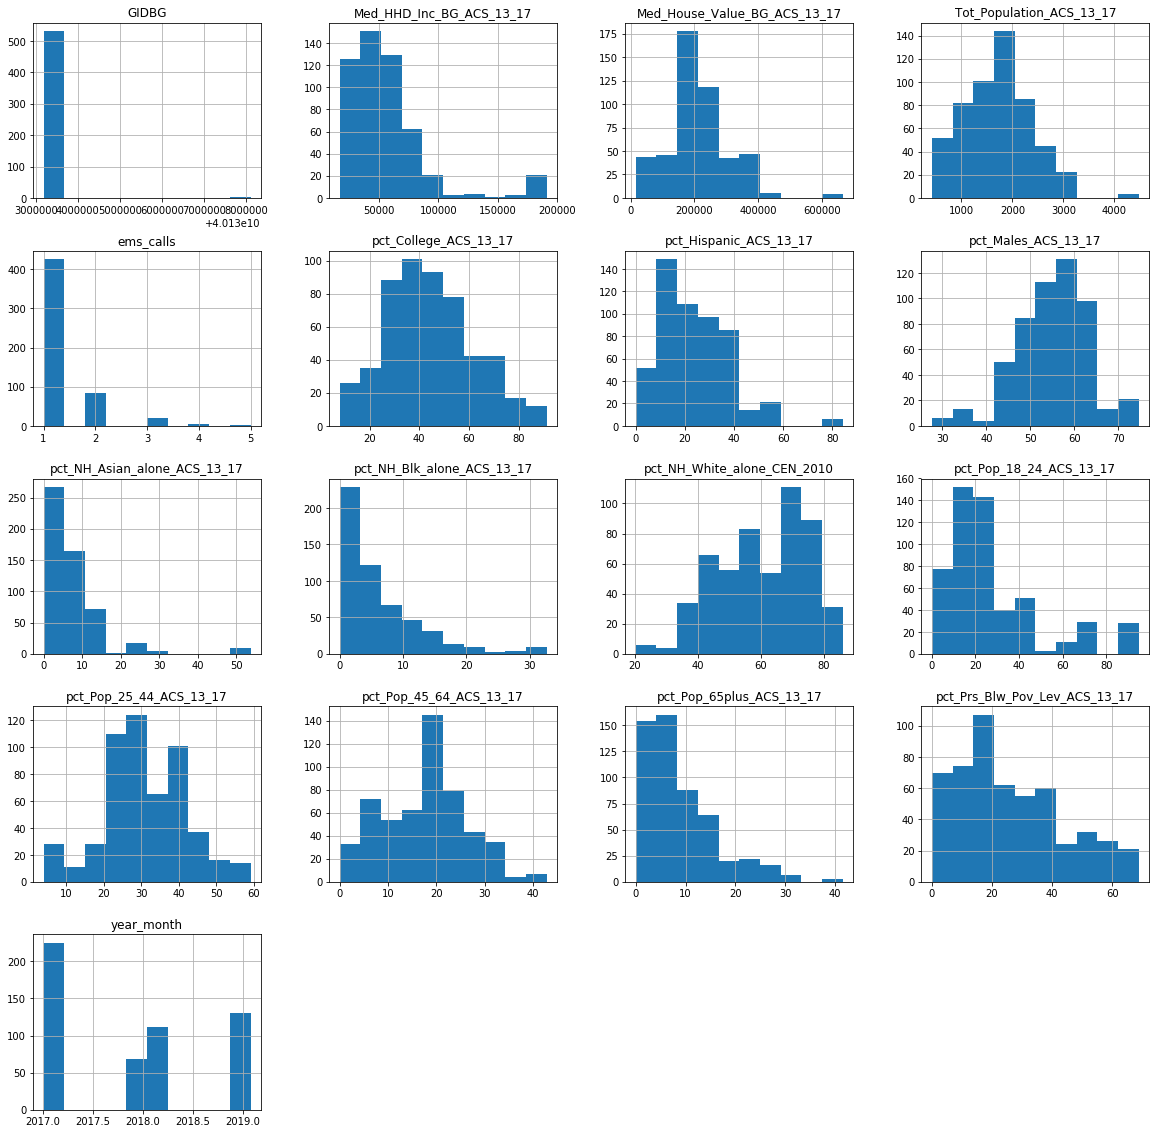

In [4]:
df.hist(figsize=(20,20))

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GIDBG,534.0,4.013321e+10,300110.843636,4.013318e+10,4.013319e+10,4.013319e+10,4.013320e+10,4.013810e+10
year_month,534.0,2.017881e+03,0.791276,2.017010e+03,2.017070e+03,2.018030e+03,2.018120e+03,2.019080e+03
Tot_Population_ACS_13_17,534.0,1.695079e+03,646.812938,4.230000e+02,1.230250e+03,1.777000e+03,2.079000e+03,4.477000e+03
pct_Males_ACS_13_17,534.0,5.480345e+01,8.190265,2.757000e+01,4.935000e+01,5.546000e+01,6.054250e+01,7.473000e+01
pct_Pop_18_24_ACS_13_17,534.0,2.810507e+01,21.813523,0.000000e+00,1.481500e+01,2.289000e+01,3.405000e+01,9.491000e+01
pct_Pop_25_44_ACS_13_17,534.0,3.088386e+01,10.842533,3.950000e+00,2.404000e+01,2.970000e+01,3.957000e+01,5.914000e+01
pct_Pop_45_64_ACS_13_17,534.0,1.783614e+01,8.644418,0.000000e+00,1.119000e+01,1.876000e+01,2.279000e+01,4.287000e+01
pct_Pop_65plus_ACS_13_17,534.0,8.969551e+00,7.486050,0.000000e+00,3.550000e+00,6.970000e+00,1.230750e+01,4.154000e+01
pct_Hispanic_ACS_13_17,534.0,2.379639e+01,14.048954,0.000000e+00,1.287000e+01,2.221000e+01,3.277000e+01,8.418000e+01
pct_NH_White_alone_CEN_2010,534.0,6.074620e+01,14.182991,2.024000e+01,5.139000e+01,6.378000e+01,7.250000e+01,8.592000e+01


### Rapid Test Model

In [6]:
df.dropna(inplace=True)

In [7]:
X, y = df, df.ems_calls
X.drop(columns='ems_calls', inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                  380
Model:                            GLM   Df Residuals:                      364
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -441.94
Date:                Thu, 20 Feb 2020   Deviance:                       68.195
Time:                        23:05:56   Pearson chi2:                     80.4
No. Iterations:                     4   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
GIDBG                          3.035e-09   2.95e-09      1.029      0.304   -2.75e-09    8.82